# DEMO: FactChecking Chatbot with Dubawas Fact-Checks

In this notebook we will expose the implementation of a conversational system capable of answering questions over a list of documents (partially adapted from [chat-langchain](https://github.com/hwchase17/chat-langchain)).

The process can be separated into the following systems:

1. _Information Retrieval_ (IR): for each question **q** the IR system is in charge of finding the set of documents **D** where the answer is found.
2. _Question Answering_ (QA): The QA system generates the answer to question **q** using the information present in the set of documents **D** .

### Setup

In [1]:
import os
import pickle
from abc import ABC, abstractmethod
from typing import Any, Dict, Iterable, List, Optional

import gradio as gr
import numpy as np
import openai
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm
pd.set_option('display.max_colwidth', 100)

openai.api_key = os.getenv("OPENAI_API_KEY")

# Data

In [2]:
dataset_path = "../data/dubawa_claims.json"
claims = pd.read_json(dataset_path)

In [44]:
claims.head(1)

,claimReviewed,text,url
0,A no-interest loan is being offered to vulnerable Nigerians by Government Enterprise and Empower...,Claim: A WhatsApp broadcast message claims that a no-interest loan is being offered to vulnerabl...,https://dubawa.org/true-fgs-no-interest-geep-loan-is-legit


In [45]:
len(claims)

975

### Processing 

In [4]:
raw_documents = []
for _, claim in tqdm(claims.iterrows(),total=len(claims)):
    text = claim["text"]
    metadata = {
        "claimReviewed": claim["claimReviewed"],
        "url": claim["url"],
    }
    raw_documents.append({"text":text,"metadata":metadata})

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 975/975 [00:00<00:00, 16025.42it/s]


The first **design decision** is how to create the documents that will serve as sources for the QA system. 

In this case we have chosen to divide each article into segments of size less than or equal to _chunk_size_ characters (1000) with a sliding window of, at most, _chunk_overlap_ characters (200).

To make the segments semantically coherent and syntactically correct, the text is recursively divided using different separators.

In [5]:
chunk_size = 1000
chunk_overlap = 200

separators = ["\n\n", "\n", " ", ""]

In [6]:
def join_docs(docs: List[str], separator: str) -> Optional[str]:
    text = separator.join(docs)
    text = text.strip()
    if text == "":
        return None
    else:
        return text

def merge_splits(splits: Iterable[str], separator: str) -> List[str]:
    # We now want to combine these smaller pieces into medium size
    # chunks to send to the LLM.
    separator_len = len(separator)

    docs = []
    current_doc: List[str] = []
    total = 0
    for d in splits:
        _len = len(d)
        if (
            total + _len + (separator_len if len(current_doc) > 0 else 0)
            > chunk_size
        ):
            if total > chunk_size:
                print(
                    f"Created a chunk of size {total}, "
                    f"which is longer than the specified {chunk_size}"
                )
            if len(current_doc) > 0:
                doc = join_docs(current_doc, separator)
                if doc is not None:
                    docs.append(doc)
                # Keep on popping if:
                # - we have a larger chunk than in the chunk overlap
                # - or if we still have any chunks and the length is long
                while total > chunk_overlap or (
                    total + _len + (separator_len if len(current_doc) > 0 else 0)
                    > chunk_size
                    and total > 0
                ):
                    total -= len(current_doc[0]) + (
                        separator_len if len(current_doc) > 1 else 0
                    )
                    current_doc = current_doc[1:]
        current_doc.append(d)
        total += _len + (separator_len if len(current_doc) > 1 else 0)
    doc = join_docs(current_doc, separator)
    if doc is not None:
        docs.append(doc)
    return docs

def split_text(text: str) -> List[str]:
    """Split incoming text and return chunks."""
    final_chunks = []
    # Get appropriate separator to use
    for _s in separators:
        if _s == "":
            separator = _s
            break
        if _s in text:
            separator = _s
            break
    # Now that we have the separator, split the text
    if separator:
        splits = text.split(separator)
    else:
        splits = list(text)
    # Now go merging things, recursively splitting longer texts.
    _good_splits = []
    for s in splits:
        if len(s) < chunk_size:
            _good_splits.append(s)
        else:
            if _good_splits:
                merged_text = merge_splits(_good_splits, separator)
                final_chunks.extend(merged_text)
                _good_splits = []
            other_info = split_text(s)
            final_chunks.extend(other_info)
    if _good_splits:
        merged_text = merge_splits(_good_splits, separator)
        final_chunks.extend(merged_text)
    return final_chunks

In [7]:
documents = []
for document in tqdm(raw_documents):
    text = document["text"]
    metadata = document["metadata"]

    splits = split_text(text)
    for chunk in splits:
        new_doc = {"text":chunk,"metadata":metadata}
        documents.append(new_doc)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 975/975 [00:00<00:00, 20313.97it/s]


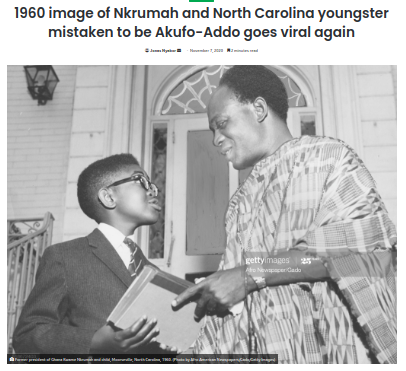


Social media user shares evidence of Kwame Nkrumah awarding Nana Akufo-Addo with book and cash prizes after debate competition decades ago.The young boy pictured with Nkrumah is 13-year-old George Miller who was at the time, the youngest student enrolled for the summer session at Columbia University.Full textAn old photo purportedly showing Ghana’s first president, Kwame Nkrumah and incumbent president, Nana Akufo-Addo, together from many years ago is once again going viral on social media.A Facebook user, John Kwadwo Stevens, recently shared the photo with the caption, “Dr. Kwame Nkrumah awarded young Akufo Addo with a book and Cash prize for excelling in a debate competition!”**It has since been shared more than 140 times.**

**It has since been shared more than 140 times.** The last time this photo went viral was in 2016 when President Akufo-Addo was campaigning to be president. A number of comments at the time flagged the photo as false even though it still continues to be believed by many to be the photograph of Nana Akufo-Addo in the photo.VerificationGiven that the photo’s purchasing license is owned by GettyImages, we accessed the photo on GettyImages’website to get further details.Per the caption on the photo, the photo was taken at Moorseville, North Carolina in the US in 1960.Beyond that detail, Getty Images did not state the identity of the little boy.“Former president of Ghana Kwame Nkrumah and child, Moorseville, North Carolina, 1960,” the photo’s caption on the website has stated.**Nana Akufo-Addo, born in 1944, was 16 years old in 1960 and according to many biographies, was in Lancing College in the UK around that time.**

**Nana Akufo-Addo, born in 1944, was 16 years old in 1960 and according to many biographies, was in Lancing College in the UK around that time.** A photo shared by the school and published on some Ghanaian news portals in 2018 including My News GH shows Akufo-Addo as a student there in 1960.With the photos taken in the US while Nana Akufo-Addo was schooling in the UK, it was unlikely that he was the one in the photo.After a series of advanced Google searches based on keywords from the caption shared by GettyImages, we found more information on the said young boy in the August 21, 1958 issue of Jet magazine hosted on Google Books.Page 24 of the magazine captures the story of a young boy who was scheduled to meet Kwame Nkrumah.The boy was named as 13-year-old George Miller who was the “youngest student enrolled in summer school at Columbia University in New York.**”He was “invited by Ghana’s Premier, Kwame Nkrumah, to attend the republic’s second-anniversary fete March 6.”**

**”He was “invited by Ghana’s Premier, Kwame Nkrumah, to attend the republic’s second-anniversary fete March 6.”**”The photo accompanying the publication had some remarkable resemblance with the youngster who featured with Kwame Nkrumah in the iconic photo.These include the glasses and his ears. Considering both images, it is very convincing that that youngster in the photo with Kwame Nkrumah was George Miller and not President Nana Akufo-Addo.Besides this point, George Miller was from the same town in which the photo with Kwame Nkrumah was taken–Moorseville, North Carolina.ConclusionBased on the evidence presented above, we conclude that the boy who featured in the photo with Kwame Nkrumah was not Nana Akufo-Addo but very likely to be that of 13-year-old George Miller of Moorseville, North Carolina.

# IR

The IR system is in charge of retrieving the set of documents where the answer is found. 

All documents and the query are represented using dense vectors, obtained through a _SentenceTransformer_ model. The relevance that a document $d$ has for the query $q$ is given by the scalar product between both, $ddot q$.

### Embeddings

In [8]:
model_name = "paraphrase-multilingual-MiniLM-L12-v2"

In [9]:
model = SentenceTransformer(model_name)

In [16]:
vectorstore = model.encode([doc["text"] for doc in documents],show_progress_bar=True)

Batches:   0%|          | 0/182 [00:00<?, ?it/s]

In [11]:
import os.path
fname = "../data/vectorstore.pkl"

In [ ]:
if not os.path.isfile(fname):
    with open(fname, "wb") as f:
        pickle.dump(vectorstore, f)

#### Si ya has codificado los documentos puedes cargar el indice ejecutando la siguiente celda 

In [12]:
with open(fname, "rb") as f:
    vectorstore = pickle.load(f)

The text _Claim: A WhatsApp broadcast message claims that a no-interest loan is being offered to vulnerable Nigerians by Government Enterprise and Empowerment Programme (GEEP) 2.0 through the Ministry of Humanitarian and Disaster Management in collaboration with the National Orientation Agency.\n\nThe GEEP loan offer was announced on the official website of the National Orientation Agency (NOA) and also on the official website of the Ministry of Humanitarian and Disaster Management.\n\nFull Text\n\nA WhatsApp broadcast message claims that the Government Enterprise and Empower Programme GEEP 2.0 through the Federal Ministry of Humanitarian and Disaster Management (FMHADM) in collaboration with the National Orientation Agency NOA is giving out non-interest loans to vulnerable Nigerians across the country._ 

Gets converted into a the vector (a list of 384 numbers): \[-0.180788398, -0.0108498204, ..., -0.297478884, 0.034035608\].

What does those **numbers represent**? **Nothing** that we can interpret as humans.
The important thing is that paragraphs or **sentences that talk about similar things are going to be represented with a very similar vector**.

Then, **when someone ask a question we can get its vector can see which are the paragrahs that are close to it and use that as our context**.

### Search

In [13]:
class Index:

    def __init__(
        self,
        documents: List[Dict[str,Any]],
        vectorstore: np.ndarray,
        model: SentenceTransformer
    ):
        self.documents = documents
        self.vectorstore = vectorstore
        self.model = model
    
    def search(
        self,
        query: str,
        k: int=4
    ):
        """Retrieves the top k documents from the index, by relevance to the query"""
        query_embedding = self.model.encode(query)
        scores = util.dot_score(query_embedding, self.vectorstore)
        scores = scores.squeeze()

        # Bigger is better
        topk = (-scores).argsort()[:k]

        return [{**self.documents[i],"score":scores[i].item() } for i in topk]

In [14]:
index = Index(documents,vectorstore,model)

# QA

In [63]:
import json
import logging
from abc import abstractmethod

import openai
from tenacity import (
    retry,
    retry_if_exception_type,
    stop_after_attempt,
    wait_random_exponential,
)

logger = logging.getLogger(__name__)


class LLM:
    @abstractmethod
    def completion(self, *args, **kwargs):
        """Generate text"""
        raise NotImplementedError

    @retry(
        wait=wait_random_exponential(min=1, max=20),
        stop=stop_after_attempt(3),
        retry=(
            retry_if_exception_type(openai.error.RateLimitError)
            | retry_if_exception_type(openai.error.ServiceUnavailableError)
        ),
    )
    def completion_with_retry(self, *args, **kwargs):
        return self.completion(*args, **kwargs)


class GPT(LLM):
    def __init__(
        self,
        model: str = "text-davinci-003",
        temperature=0.7,
        max_tokens=500,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        n=1,
        logit_bias={},
    ):
        self.params = {
            "model": model,
            "temperature": temperature,
            "max_tokens": max_tokens,
            "top_p": top_p,
            "frequency_penalty": frequency_penalty,
            "presence_penalty": presence_penalty,
            "n": n,
            "logit_bias": logit_bias,
        }

    def completion(self, prompt):
        logger.info("PROMPT: {prompt}".format(prompt=prompt))
        print(prompt)
        response = openai.Completion.create(prompt=prompt, **self.params)
        text = response.choices[0].text
        logger.info("ANSWER: {answer}".format(answer=text))
        return text


class ChatGPT(LLM):
    def __init__(
        self,
        model: str = "gpt-3.5-turbo",
        temperature=0.7,
        max_tokens=None,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        n=1,
        logit_bias={},
    ):
        self.params = {
            "model": model,
            "temperature": temperature,
            "max_tokens": max_tokens,
            "top_p": top_p,
            "frequency_penalty": frequency_penalty,
            "presence_penalty": presence_penalty,
            "n": n,
            "logit_bias": logit_bias,
        }

    def completion(
        self, prompt, system_message="You are a helpful assistant.", history=None
    ):
        messages = []
        if history:
            messages.extend(history)
        elif system_message:
            messages.append({"role": "system", "content": system_message})
        messages.append({"role": "user", "content": prompt})

        logger.info(
            "MESSAGES: {messages}".format(messages=json.dumps(messages, indent=4))
        )
        response = openai.ChatCompletion.create(messages=messages, **self.params)
        text = response.choices[0].message["content"]
        logger.info("ANSWER: {answer}".format(answer=text))
        return text

In [64]:
llm = GPT()

# Chat

### Prompts

In [65]:
document_separator = '\n\n'

In [66]:
question_template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

{context}

Question: {question}
Helpful Answer:"""

history_template = """Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question.

Chat History:
{chat_history}
Follow Up Input: {question}
Standalone question:"""

### Chatbot

In [67]:
class ChatQA:

    def __init__(
        self,
        ir,
        qa
    ):
        self.ir = ir
        self.qa = qa

        self.history = []

    def reset(self):
        self.history = []
        
    def follow_up_query(self,question):
        prompt = history_template.format(chat_history="/n".join(self.history),question=question)
        query = self.qa.completion(prompt)
        return query

    def __call__(
        self,
        question:str
    ):
        if len(self.history):
            query = self.follow_up_query(question)
        else:
            query = question

        documents = self.ir.search(query)

        contexts = [document["text"] for document in documents]
        context = document_separator.join(contexts)
        prompt =  question_template.format(context=context,question=query)

        answer = self.qa.completion(prompt)

        self.history.append("\n".join([prompt,answer]))

        urls = [document["metadata"]["url"] for document in documents]
        urls = list(dict.fromkeys(urls))
        citation = [f'{i+1}. {url}' for i,url in enumerate(urls)]

        return "\n".join([answer,*citation])

In [68]:
chat = ChatQA(index,llm)

### Ejemplos

In [69]:
question = 'Is not wearing a mask in public places considered a criminal offense in Ghana?'

In [70]:
print(ChatQA(index,llm)(question))

Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

Verification

Dubawa found that the same post has been shared on Facebook with comments indicating that the message originates from Kenya.

Further checks show the legislation was enacted in Kenya and not Ghana as the messages sought to suggest.

Google checks revealed that Kenyan media outlets here, here, and here published articles on the penalty of not wearing face masks between 9 and 15 April 2020.

Their publications indicated that the Kenyan government had issued a gazette stating that citizens were required to wear a proper nose mask that covers their mouth and nose. Anyone who contravened the rules was considered to have committed an offence liable to a fine not exceeding 20,000 shillings, imprisonment not exceeding 6-months or both.

Dubawa further found a copy of the Kenya Gazette Supplement No 41, a special issue 

In [41]:
question = 'Is it true that lemon juice on an empty stomach help with weight loss?'

In [42]:
print(ChatQA(index,llm)(question))

 No, it is not true that lemon juice on an empty stomach helps with weight loss. Studies have found that lemon juice can produce ACE which prevents an enzyme in the body from creating angiotensin II which causes a narrowing of the blood vessels, and this may result in weight loss. However, it is not recommended to drink lemon juice on an empty stomach as it may be too acidic and can cause health issues.
1. https://ghana.dubawa.org/drinking-coffee-with-lemon-will-not-cause-melting-of-body-fat


In [43]:
question = 'Why was Nicolás Maduro attacked by a group of people in San Felix (Venezuela) in 2022?'
print(ChatQA(index,llm)(question))

 I don't know.
1. https://ghana.dubawa.org/no-italians-are-not-throwing-away-money
2. https://dubawa.org/is-buhari-supporting-a-notorious-herdsman
3. https://dubawa.org/peter-obis-convoy-was-not-attacked-in-abuja-market
4. https://dubawa.org/over-50-journalists-have-been-attacked-in-nigeria-this-year


# Demo

In [37]:
def reset_chat():
    chat.reset()
    return ''

with gr.Blocks() as demo:
    chatbot = gr.Chatbot()
    chat = ChatQA(index,llm)
    msg = gr.Textbox(placeholder="Enter text and press enter, or upload an image",)
    clear = gr.Button("Clear")

    def respond(question, chat_history):
        bot_message = chat(question)
        chat_history.append((question, bot_message))
        return "", chat_history

    msg.submit(respond, [msg, chatbot], [msg, chatbot])
    clear.click(reset_chat, None, chatbot, queue=False)

demo.launch();

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
